Restarted myenv (Python 3.10.13)

In [ ]:
from tqdm import tqdm
import time
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
import torch.nn as nn
from SAE import TopKSparseAutoencoder
import transformer_lens
from torch.cuda.amp import autocast
import os
import matplotlib.pyplot as plt
from tiny_story_data import load_tiny_stories_data
from torch.cuda.amp import GradScaler
import torch.optim as optim
import torch.nn.utils as utils

lambda_adv = 0.2

print("packages imported")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
cuda_mem_in_use = []

/root/advint/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


packages imported


In [ ]:
# Load model
model = transformer_lens.HookedTransformer.from_pretrained("tiny-stories-33M")
print("model loaded")

Loaded pretrained model tiny-stories-33M into HookedTransformer
model loaded


In [ ]:
# Check for cuda device
if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x)
else:
    device = torch.device("cpu")
    print("Cuda device not found. Using CPU.")

model.to(device)


# Run the model and get logits and activations
logits, activations = model.run_with_cache(["this", "is", "a", "test"])

activation_key = f'blocks.{2}.hook_resid_post'

print(activations[activation_key].shape)

tensor([1.], device='cuda:0')
Moving model to device:  cuda
torch.Size([4, 2, 768])


In [ ]:
#check if data is loaded and tokenised, otherwise load it tokenise it and save it to a .pt file
if os.path.exists("train_tokens.pt"):
    train_tokens = torch.load('train_tokens.pt')
    val_tokens = torch.load('val_tokens.pt')
    print("loaded data from local")
else:
    print("tokenising data")
    load_tiny_stories_data()
    train_tokens = torch.load('train_tokens.pt')
    val_tokens = torch.load('val_tokens.pt')
    print("data loaded")

loaded data from local


In [ ]:
torch.cuda.empty_cache()
# Convert tokenized tensors to TensorDataset
train_dataset = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'])
val_dataset = TensorDataset(val_tokens['input_ids'], val_tokens['attention_mask'])



# DataLoader settings
# DataLoader settings
batch_size = 128  # Set your desired batch size
num_workers = 16  # Adjust this based on your system's CPU capacity
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

# Define your SAE and training components
latent_dim = 768 * 10  # 8192
embedding_dim = 768  # Replace with actual embedding dim from the model

SAE = TopKSparseAutoencoder(input_dim=embedding_dim, latent_dim=latent_dim).to(device)
sae_optimizer = Adam(SAE.parameters(), lr=5e-4)

# Loss functions
mse_loss_fn = MSELoss()
l1_loss_fn = L1Loss()
max_grad_norm = 1.0  # Gradient clipping value

# Training SAE
num_epochs = 1
activation_key = f'blocks.{2}.hook_resid_post'  # Layer 2 residual stream

# Initialize GradScaler
scaler = GradScaler()

sae_losses = []
SAE.train()
model.eval()

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hoo

In [ ]:
# Define hook function to capture activations
activation_key = f'blocks.{2}.hook_resid_post'
activations = None


def activation_hook(module, input, output):
    global activations
    activations = output


# Register hook
hook = model.get_submodule(activation_key).register_forward_hook(activation_hook)

starting SAE training
Epoch 0


Epoch 1:   1%|          | 100/16561 [00:54<2:30:14,  1.83it/s]

Batch 101/16561: Recon Loss=0.1575, Sparsity Loss=0.0448, Avg Time per Batch=0.5463s


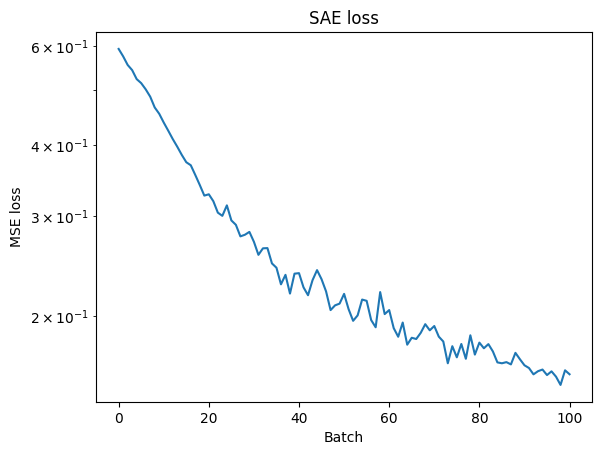

Epoch 1:   1%|          | 200/16561 [01:50<2:29:10,  1.83it/s]

Batch 201/16561: Recon Loss=0.1066, Sparsity Loss=0.0475, Avg Time per Batch=0.5453s


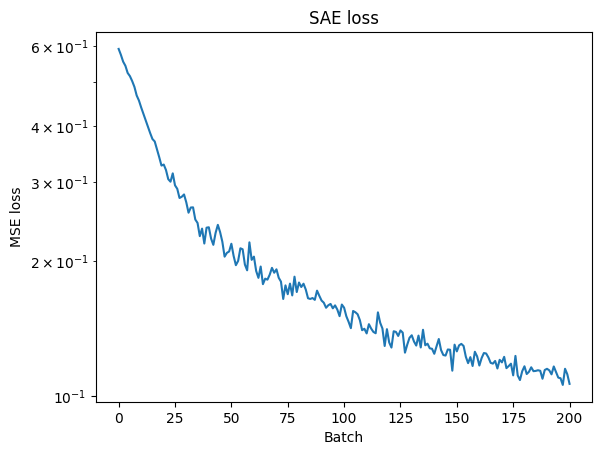

Epoch 1:   2%|▏         | 300/16561 [02:44<2:27:51,  1.83it/s]

Batch 301/16561: Recon Loss=0.0903, Sparsity Loss=0.0456, Avg Time per Batch=0.5445s


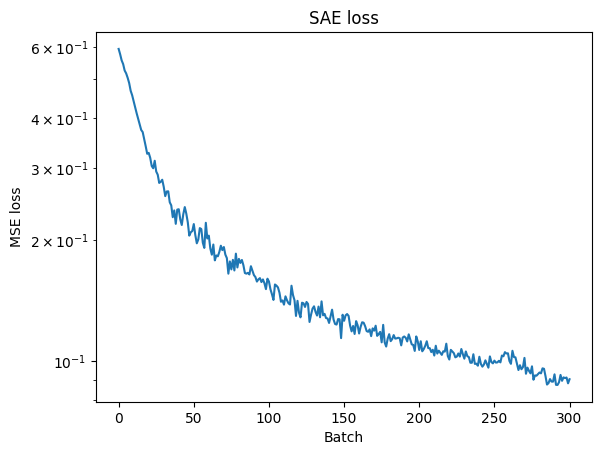

Epoch 1:   2%|▏         | 400/16561 [03:39<2:26:55,  1.83it/s]

Batch 401/16561: Recon Loss=0.0761, Sparsity Loss=0.0439, Avg Time per Batch=0.5441s


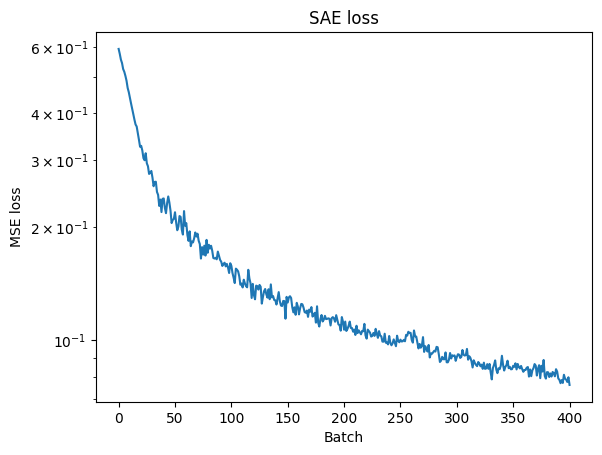

Epoch 1:   3%|▎         | 500/16561 [04:34<2:26:01,  1.83it/s]

Batch 501/16561: Recon Loss=0.0688, Sparsity Loss=0.0423, Avg Time per Batch=0.5439s


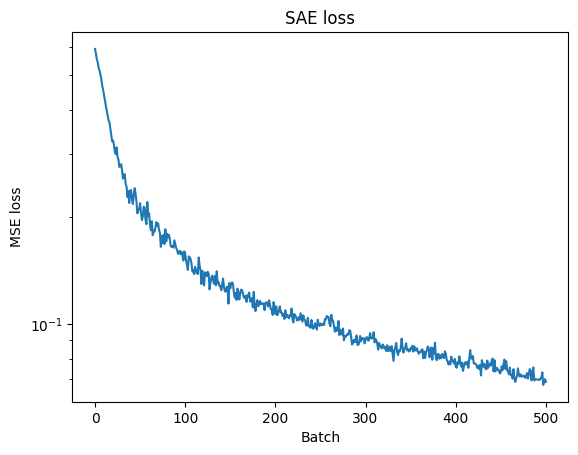

Epoch 1:   4%|▎         | 600/16561 [05:29<2:25:04,  1.83it/s]

Batch 601/16561: Recon Loss=0.0603, Sparsity Loss=0.0407, Avg Time per Batch=0.5437s


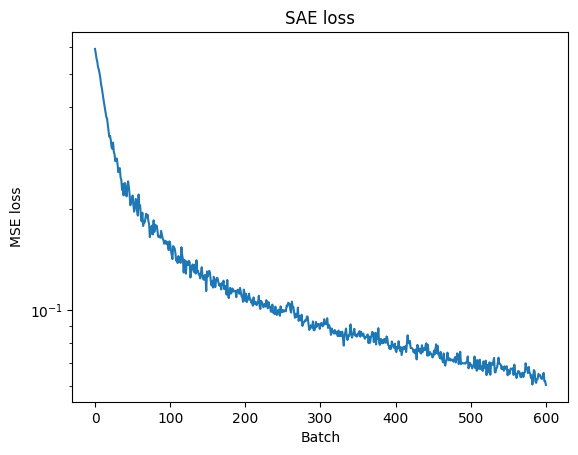

Epoch 1:   4%|▍         | 700/16561 [06:23<2:24:09,  1.83it/s]

Batch 701/16561: Recon Loss=0.0588, Sparsity Loss=0.0392, Avg Time per Batch=0.5436s


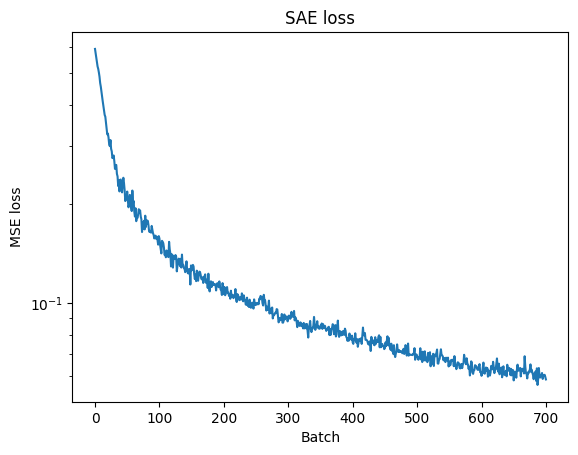

Epoch 1:   5%|▍         | 800/16561 [07:18<2:23:25,  1.83it/s]

Batch 801/16561: Recon Loss=0.0551, Sparsity Loss=0.0379, Avg Time per Batch=0.5436s


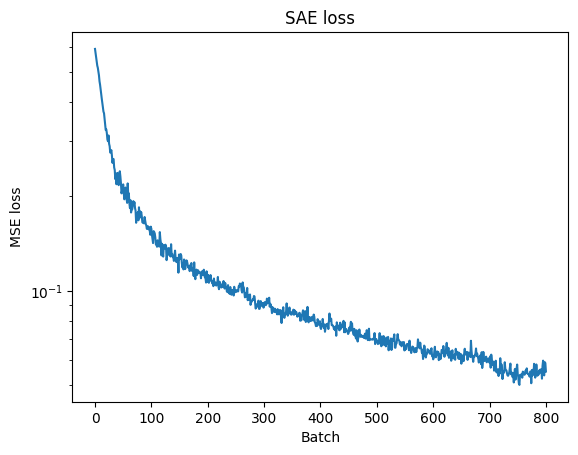

Epoch 1:   5%|▌         | 900/16561 [08:13<2:22:38,  1.83it/s]

Batch 901/16561: Recon Loss=0.0512, Sparsity Loss=0.0367, Avg Time per Batch=0.5437s


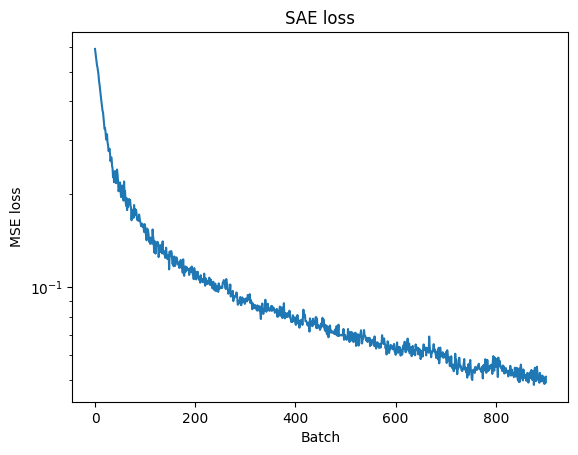

Epoch 1:   6%|▌         | 1000/16561 [09:08<2:21:41,  1.83it/s]

Batch 1001/16561: Recon Loss=0.0463, Sparsity Loss=0.0366, Avg Time per Batch=0.5437s


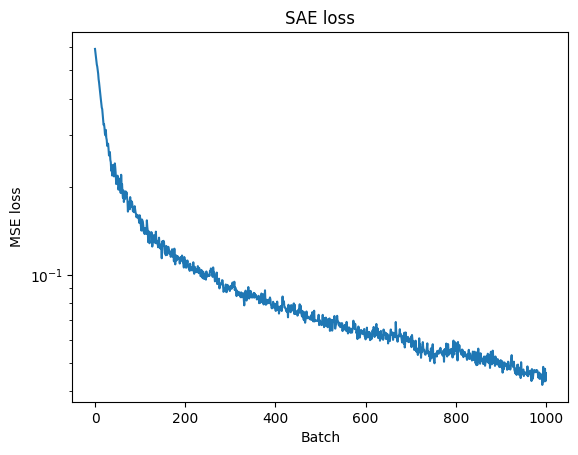

Epoch 1:   7%|▋         | 1100/16561 [10:03<2:20:40,  1.83it/s]

Batch 1101/16561: Recon Loss=0.0408, Sparsity Loss=0.0353, Avg Time per Batch=0.5437s


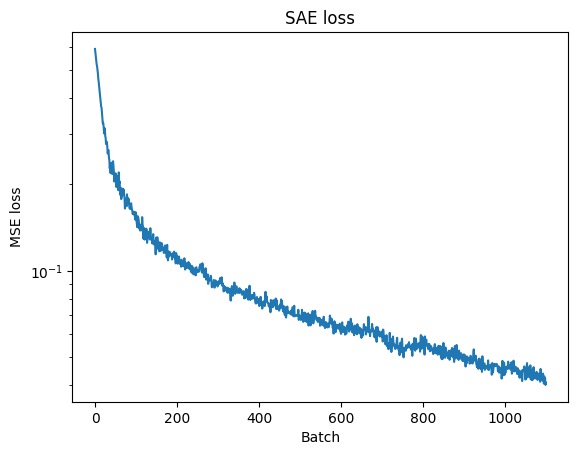

KeyboardInterrupt: 

In [ ]:
print("starting SAE training")
# Training Loop
# Training Loop

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    cumulative_sae_recon_loss, cumulative_sae_sparsity_loss = 0, 0
    cumulative_batch_time = 0  # To accumulate batch processing times

    # Progress bar for each batch within the epoch
    for batch_idx, (input_ids, attention_mask) in tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}", total=len(train_loader), leave=False):
        # Model forward pass
        start_time = time.time()
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        
        sae_optimizer.zero_grad()
        
        
        # SAE forward pass
        # SAE forward pass
        with autocast():
            with torch.no_grad():
                _ = model(input_ids)  # Forward pass to trigger hook
            reconstructed, latent = SAE(activations)
            
            # Loss calculation
            sae_reconstruction_loss = mse_loss_fn(reconstructed, activations)
            sae_sparsity_loss = l1_loss_fn(latent, torch.zeros_like(latent))
            total_sae_loss = sae_reconstruction_loss

        # SAE backward pass with gradient scaling
        scaler.scale(total_sae_loss).backward()

        # Gradient clipping and optimizer step
        torch.nn.utils.clip_grad_norm_(SAE.parameters(), max_grad_norm)
        scaler.step(sae_optimizer)
        scaler.update()

        # Track and display batch losses
        cumulative_sae_recon_loss += sae_reconstruction_loss.item()
        cumulative_sae_sparsity_loss += sae_sparsity_loss.item()
        sae_losses.append(sae_reconstruction_loss.item())

        # Track batch time
        batch_time = time.time() - start_time
        cumulative_batch_time += batch_time

        # Print progress every 100 batches
        if batch_idx % 100 == 0 and batch_idx > 0:
            avg_time_per_batch = cumulative_batch_time / (batch_idx + 1)
            print(f"Batch {batch_idx + 1}/{len(train_loader)}: "
                  f"Recon Loss={sae_reconstruction_loss.item():.4f}, "
                  f"Sparsity Loss={sae_sparsity_loss.item():.4f}, "
                  f"Avg Time per Batch={avg_time_per_batch:.4f}s")
            plt.plot(sae_losses)
            plt.yscale("log")
            plt.title("SAE loss")
            plt.xlabel("Batch")
            plt.ylabel("MSE loss")
            plt.show()
            #break

    # Average epoch losses
    avg_recon_loss = cumulative_sae_recon_loss / len(train_loader)
    avg_sparsity_loss = cumulative_sae_sparsity_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Recon Loss: {avg_recon_loss:.4f}, Avg Sparsity Loss: {avg_sparsity_loss:.4f}")

print("SAE Training Complete!")

# Remove hook after training
hook.remove()

In [ ]:
torch.cuda.empty_cache()


model.train()
SAE.train()
batch_size = 32
train_loader_2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_2 = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)


optimizer = optim.Adam(model.parameters(), lr=5e-3)
sae_optimizer = optim.Adam(SAE.parameters(), lr=5e-4)

criterion = nn.CrossEntropyLoss()

# Initialize cumulative metrics for epoch
cumulative_ce_loss = 0
cumulative_combined_loss = 0
cumulative_accuracy = 0
cumulative_sae_recon_loss = 0
cumulative_sae_sparsity_loss = 0
batch_count = 0  # To keep track of batches for plotting
batch_losses = []
batch_ce_losses = []
batch_combined_losses = []
batch_accuracies = []
batch_sae_recon_losses = []
batch_sae_sparsity_losses = []
batch_sae_total_losses = []

: 

In [ ]:
for batch_idx, (input_ids, attention_mask) in tqdm(enumerate(train_loader_2), desc=f"Epoch 1", total=len(train_loader_2), leave=False):
    

    inputs = input_ids[:, :-1]  # Use all tokens except the last one as input
    targets = input_ids[:, 1:]
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    optimizer.zero_grad()
    sae_optimizer.zero_grad()
    
    with autocast():

        
        logits = model(inputs)  # Forward pass to trigger hook

        reconstructed, latent = SAE(activations)
        # Loss calculation
        sae_reconstruction_loss = mse_loss_fn(reconstructed, activations)
        sae_sparsity_loss = l1_loss_fn(latent, torch.zeros_like(latent))
        total_sae_loss = sae_reconstruction_loss
        
        logits_reshaped = logits.reshape(-1, logits.size(-1))  # Shape: [batch_size * seq_length, vocab_size]
        targets_reshaped = targets.view(-1)  # Shape: [batch_size * seq_length]
        ce_loss = criterion(logits_reshaped, targets_reshaped)

        combined_loss = ce_loss - lambda_adv * torch.log(sae_reconstruction_loss)
        #combined_loss = kl_loss + lambda_adv * (1/sae_reconstruction_loss)
    # 1. Freeze SAE's parameters to prevent them from being updated during combined_loss backward
    
    for param in SAE.parameters():
        param.requires_grad = False

    # 2. Backward pass for combined_loss (updates main model only)
    scaler.scale(combined_loss).backward(retain_graph=True)

    # 3. Unfreeze SAE's parameters to allow updates from total_sae_loss
    for param in SAE.parameters():
        param.requires_grad = True

    # 4. Backward pass for total_sae_loss (updates SAE only)
    scaler.scale(total_sae_loss).backward()


    # 6. Clip gradients for the main model
    utils.clip_grad_norm_(model.parameters(), max_grad_norm)

    # 7. Clip gradients for the SAE
    utils.clip_grad_norm_(SAE.parameters(), max_grad_norm)

    # 6. Normalize decoder weights
    SAE.decoder.weight.data = SAE.decoder.weight.data / SAE.decoder.weight.data.norm(dim=1, keepdim=True)


    # 5. Update optimizers
    scaler.step(optimizer)
    scaler.step(sae_optimizer)

    # 6. Update the scaler
    scaler.update()

    with torch.no_grad():
        predictions = torch.argmax(logits_reshaped, dim=-1) 
        correct = (predictions == targets_reshaped).float()    
        attention_mask_reshaped = attention_mask[:, 1:].reshape(-1) 
        correct *= attention_mask_reshaped
        accuracy = correct.sum() / attention_mask_reshaped.sum()


    # Accumulate metrics
    cumulative_ce_loss += ce_loss.item()
    cumulative_combined_loss += combined_loss.item()
    cumulative_accuracy += accuracy.item()
    cumulative_sae_recon_loss += sae_reconstruction_loss.item()
    cumulative_sae_sparsity_loss += sae_sparsity_loss.item()
    batch_count += 1

    # Store batch metrics for plotting
    batch_losses.append(combined_loss.item())
    batch_ce_losses.append(ce_loss.item())
    batch_combined_losses.append(combined_loss.item())
    batch_accuracies.append(accuracy.item())
    batch_sae_recon_losses.append(sae_reconstruction_loss.item())
    batch_sae_sparsity_losses.append(sae_sparsity_loss.item())
    batch_sae_total_losses.append(total_sae_loss.item())

    if batch_idx % 100 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        axs[0].plot(batch_combined_losses, label='Combined Loss')
        axs[0].plot(batch_ce_losses, label='CE Loss')
        axs[0].set_yscale('log')
        axs[0].set_xlabel('Batch')
        axs[0].set_ylabel('Loss (Log Scale)')
        axs[0].set_title(f'Combined Loss ')
        axs[0].legend()
        axs[0].grid(True)

        # Subplot 2: Accuracy
        axs[1].plot([acc * 100 for acc in batch_accuracies], label='Accuracy (%)', color='green')
        axs[1].set_xlabel('Batch')
        axs[1].set_ylabel('Accuracy (%)')
        axs[1].set_title(f'Accuracy ')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.savefig(f"training_graph_model_adv_{lambda_adv}.pdf")
        plt.show()
        # Plot SAE's Reconstruction, Sparsity, and Total Loss
        plt.figure(figsize=(18, 5))

        plt.plot(batch_sae_total_losses, label='Total SAE Loss', color='red')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title(f'Loss SAE')
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"training_graph_SAE_adv_{lambda_adv}.pdf")
        plt.show()



print("Training Complete!")

: 

In [ ]:
# Subplot 1: Combined Loss (log scale)
# Plot Main Model's Loss and Accuracy
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(batch_combined_losses, label='Combined Loss')
axs[0].plot(batch_ce_losses, label='CE Loss')
axs[0].set_yscale('log')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss (Log Scale)')
axs[0].set_title(f'Combined Loss ')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Accuracy
axs[1].plot([acc * 100 for acc in batch_accuracies], label='Accuracy (%)', color='green')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title(f'Accuracy ')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig(f"training_graph_model_adv_{lambda_adv}.pdf")
plt.show()
# Plot SAE's Reconstruction, Sparsity, and Total Loss
plt.figure(figsize=(18, 5))

plt.plot(batch_sae_total_losses, label='Total SAE Loss', color='red')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title(f'Loss SAE')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.savefig(f"training_graph_SAE_adv_{lambda_adv}.pdf")
plt.show()

: 

In [ ]:
torch.cuda.empty_cache()


model.train()
SAE.train()
batch_size = 32
train_loader_2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader_2 = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)


optimizer = optim.Adam(model.parameters(), lr=5e-3)
sae_optimizer = optim.Adam(SAE.parameters(), lr=5e-4)

criterion = nn.CrossEntropyLoss()

# Initialize cumulative metrics for epoch
cumulative_ce_loss = 0
cumulative_combined_loss = 0
cumulative_accuracy = 0
cumulative_sae_recon_loss = 0
cumulative_sae_sparsity_loss = 0
batch_count = 0  # To keep track of batches for plotting
batch_losses = []
batch_ce_losses = []
batch_combined_losses = []
batch_accuracies = []
batch_sae_recon_losses = []
batch_sae_sparsity_losses = []
batch_sae_total_losses = []

In [ ]:
for batch_idx, (input_ids, attention_mask) in tqdm(enumerate(train_loader_2), desc=f"Epoch 1", total=len(train_loader_2), leave=False):
    

    inputs = input_ids[:, :-1]  # Use all tokens except the last one as input
    targets = input_ids[:, 1:]
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    optimizer.zero_grad()
    sae_optimizer.zero_grad()
    
    with autocast():

        
        logits = model(inputs)  # Forward pass to trigger hook

        reconstructed, latent = SAE(activations)
        # Loss calculation
        sae_reconstruction_loss = mse_loss_fn(reconstructed, activations)
        sae_sparsity_loss = l1_loss_fn(latent, torch.zeros_like(latent))
        total_sae_loss = sae_reconstruction_loss
        
        logits_reshaped = logits.reshape(-1, logits.size(-1))  # Shape: [batch_size * seq_length, vocab_size]
        targets_reshaped = targets.view(-1)  # Shape: [batch_size * seq_length]
        ce_loss = criterion(logits_reshaped, targets_reshaped)

        combined_loss = ce_loss - lambda_adv * torch.log(sae_reconstruction_loss)
        #combined_loss = kl_loss + lambda_adv * (1/sae_reconstruction_loss)
    # 1. Freeze SAE's parameters to prevent them from being updated during combined_loss backward
    
    for param in SAE.parameters():
        param.requires_grad = False

    # 2. Backward pass for combined_loss (updates main model only)
    scaler.scale(combined_loss).backward(retain_graph=True)

    # 3. Unfreeze SAE's parameters to allow updates from total_sae_loss
    for param in SAE.parameters():
        param.requires_grad = True

    # 4. Backward pass for total_sae_loss (updates SAE only)
    scaler.scale(total_sae_loss).backward()


    # 6. Clip gradients for the main model
    utils.clip_grad_norm_(model.parameters(), max_grad_norm)

    # 7. Clip gradients for the SAE
    utils.clip_grad_norm_(SAE.parameters(), max_grad_norm)

    # 6. Normalize decoder weights
    SAE.decoder.weight.data = SAE.decoder.weight.data / SAE.decoder.weight.data.norm(dim=1, keepdim=True)


    # 5. Update optimizers
    scaler.step(optimizer)
    scaler.step(sae_optimizer)

    # 6. Update the scaler
    scaler.update()

    with torch.no_grad():
        predictions = torch.argmax(logits_reshaped, dim=-1) 
        correct = (predictions == targets_reshaped).float()    
        attention_mask_reshaped = attention_mask[:, 1:].reshape(-1) 
        correct *= attention_mask_reshaped
        accuracy = correct.sum() / attention_mask_reshaped.sum()


    # Accumulate metrics
    cumulative_ce_loss += ce_loss.item()
    cumulative_combined_loss += combined_loss.item()
    cumulative_accuracy += accuracy.item()
    cumulative_sae_recon_loss += sae_reconstruction_loss.item()
    cumulative_sae_sparsity_loss += sae_sparsity_loss.item()
    batch_count += 1

    # Store batch metrics for plotting
    batch_losses.append(combined_loss.item())
    batch_ce_losses.append(ce_loss.item())
    batch_combined_losses.append(combined_loss.item())
    batch_accuracies.append(accuracy.item())
    batch_sae_recon_losses.append(sae_reconstruction_loss.item())
    batch_sae_sparsity_losses.append(sae_sparsity_loss.item())
    batch_sae_total_losses.append(total_sae_loss.item())

    if batch_idx % 100 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        axs[0].plot(batch_combined_losses, label='Combined Loss')
        axs[0].plot(batch_ce_losses, label='CE Loss')
        axs[0].set_yscale('log')
        axs[0].set_xlabel('Batch')
        axs[0].set_ylabel('Loss (Log Scale)')
        axs[0].set_title(f'Combined Loss ')
        axs[0].legend()
        axs[0].grid(True)

        # Subplot 2: Accuracy
        axs[1].plot([acc * 100 for acc in batch_accuracies], label='Accuracy (%)', color='green')
        axs[1].set_xlabel('Batch')
        axs[1].set_ylabel('Accuracy (%)')
        axs[1].set_title(f'Accuracy ')
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.savefig(f"training_graph_model_adv_{lambda_adv}.pdf")
        plt.show()
        # Plot SAE's Reconstruction, Sparsity, and Total Loss
        plt.figure(figsize=(18, 5))

        plt.plot(batch_sae_total_losses, label='Total SAE Loss', color='red')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title(f'Loss SAE')
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"training_graph_SAE_adv_{lambda_adv}.pdf")
        plt.show()



print("Training Complete!")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!